In [2]:
import csv
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
data = []
with open('shot_logs.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        for row in reader:
            data.append(row)

In [4]:
categories = ['game_id','matchup','location','win/lose','final_margin','shot_number','period','game_clock',
             'shot_clock','dribbles','touch_time','shot_dist','pts_type','shot_result','closest_def_name',
             'closest_def_id','closest_def_dist','fgm','pts','player_name', 'player_id']

shot_dict = {}
for i in range(len(data)):
    shot_dict[i] = dict(zip(categories, data[i]))

In [5]:
labels = [int(shot_dict[i]['fgm']) for i in range(len(data))]

In [6]:
dribbles = [float(shot_dict[i]['dribbles']) for i in range(len(data))]
shot_dist = [float(shot_dict[i]['shot_dist']) for i in range(len(data))]
pts_type = [float(shot_dict[i]['pts_type']) for i in range(len(data))]
closest_def_dist = [float(shot_dict[i]['closest_def_dist']) for i in range(len(data))] 

In [51]:
players = set([shot_dict[i]['player_name'] for i in range(len(data))])

In [74]:
shot_dict[0]['final_margin']

'24'

# Data cleanup

In [57]:
# Cleaning shot_dict
for i in range(len(data)):
    if shot_dict[i]['shot_clock'] == '':
        shot_dict[i]['shot_clock'] = 0
    if shot_dict[i]['dribbles'] == '':
         shot_dict[i]['dribbles'] = 0
            
    if shot_dict[i]['location'] == 'A':
        shot_dict[i]['location'] = 0
    else:
        shot_dict[i]['location'] = 1
        
    if shot_dict[i]['win/lose'] == 'L':
        shot_dict[i]['win/lose'] = 0
    else:
        shot_dict[i]['win/lose'] = 1

In [75]:
shot_clock = [float(shot_dict[i]['shot_clock']) for i in range(len(data))]

In [203]:
dribbles_zip = list(zip(dribbles,labels))
shot_dist_zip = list(zip(shot_dist,labels))
pts_type_zip = list(zip(pts_type,labels))
shot_clock_zip = list(zip(shot_clock,labels))
closest_def_dist_zip = list(zip(closest_def_dist,labels))

In [204]:
dribbles_made = [d[0] for d in dribbles_zip if d[1] == 1]
shot_dist_made = [d[0] for d in shot_dist_zip if d[1] == 1]
pts_type_made = [d[0] for d in pts_type_zip if d[1] == 1]
shot_clock_made = [d[0] for d in shot_clock_zip if d[1] == 1]
closest_def_dist_made = [d[0] for d in closest_def_dist_zip if d[1] == 1]

In [211]:
print(max([d for d in dribbles_made]))
print(max([d for d in shot_dist_made]))
print(max([d for d in pts_type_made]))
print(max([d for d in shot_clock_made]))
print(max([d for d in closest_def_dist_made]))

30.0
47.2
3.0
24.0
53.2


In [209]:
num_rows = 5

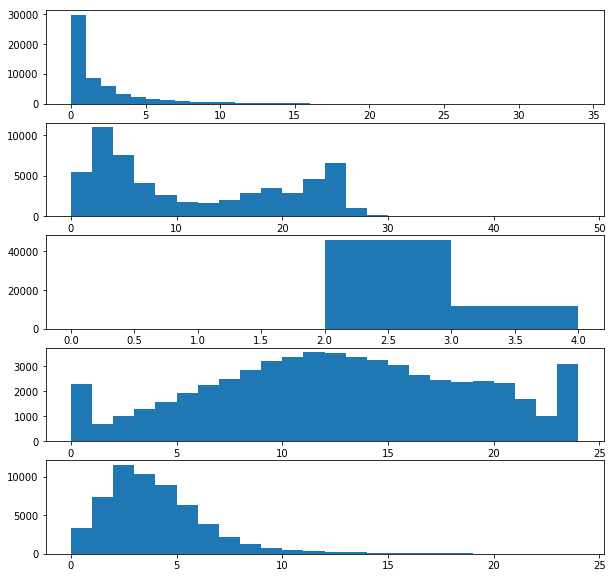

In [224]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(num_rows, 1, 1)
dribble1, bins, patches = ax1.hist(dribbles_made,list(range(0,35)))
ax2 = fig.add_subplot(num_rows, 1, 2)
dist1, bins, patches = ax2.hist(shot_dist_made,list(range(0,50,2)))
ax3 = fig.add_subplot(num_rows, 1, 3)
type1, bins, patches = ax3.hist(pts_type_made,[0,1,2,3,4])
ax4 = fig.add_subplot(num_rows, 1, 4)
clock1, bins, patches = ax4.hist(shot_clock_made,list(range(0,25)))
ax4 = fig.add_subplot(num_rows, 1, 5)
closest_def_dist1, bins, patches = ax4.hist(closest_def_dist_made,list(range(0,25)))

In [213]:
dribbles_notmade = [d[0] for d in dribbles_zip if d[1] == 0]
shot_dist_notmade = [d[0] for d in shot_dist_zip if d[1] == 0]
pts_type_notmade = [d[0] for d in pts_type_zip if d[1] == 0]
shot_clock_notmade = [d[0] for d in shot_clock_zip if d[1] == 0]
closest_def_dist_notmade = [d[0] for d in closest_def_dist_zip if d[1] == 0]

In [215]:
print(max([d for d in dribbles_notmade]))
print(max([d for d in shot_dist_notmade]))
print(max([d for d in pts_type_notmade]))
print(max([d for d in shot_clock_notmade]))
print(max([d for d in closest_def_dist_notmade]))

32.0
46.9
3.0
24.0
28.1


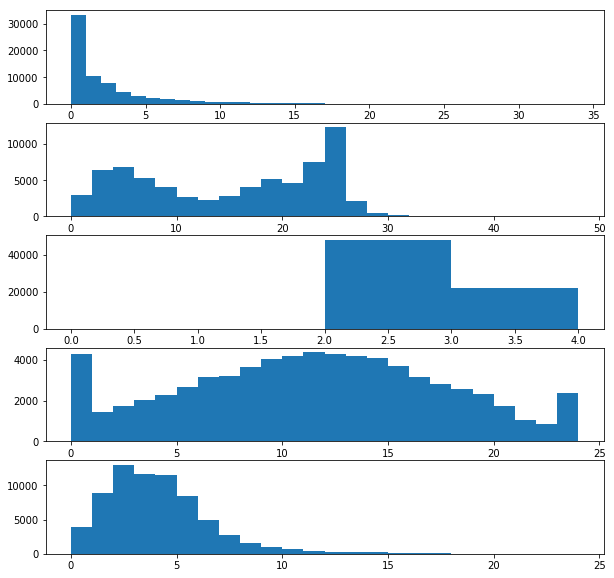

In [221]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(num_rows, 1, 1)
dribble0, bins, patches = ax1.hist(dribbles_notmade,list(range(0,35)))
ax2 = fig.add_subplot(num_rows, 1, 2)
dist0, bins, patches = ax2.hist(shot_dist_notmade,list(range(0,50,2)))
ax3 = fig.add_subplot(num_rows, 1, 3)
type0, bins, patches = ax3.hist(pts_type_notmade,[0,1,2,3,4])
ax4 = fig.add_subplot(num_rows, 1, 4)
clock0, bins, patches = ax4.hist(shot_clock_notmade,list(range(0,25)))
ax4 = fig.add_subplot(num_rows, 1, 5)
closest_def_dist0, bins, patches = ax4.hist(closest_def_dist_notmade,list(range(0,25)))

# Finding relevant ratios

In [61]:
def createPlot(category):
    cat_data = [float(shot_dict[i][category]) for i in range(len(data))]
    cat_zip = list(zip(cat_data,labels))
    made = [d[0] for d in cat_zip if d[1] == 1]
    x_axis = range(len(range(0,int(max(made)+2))))
    made_counts, _= np.histogram(made,x_axis)
    notmade = [d[0] for d in cat_zip if d[1] == 0]
    notmade_counts, _= np.histogram(notmade,x_axis)

    ratio = np.divide(made_counts, made_counts+notmade_counts)
    return ratio, x_axis[:-1]

In [75]:
categories = ['dribbles', 'shot_clock', 'shot_dist', 'pts_type','closest_def_dist', 'touch_time', 'location',
             'win/lose', 'period', 'final_margin']

/Users/ryanle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


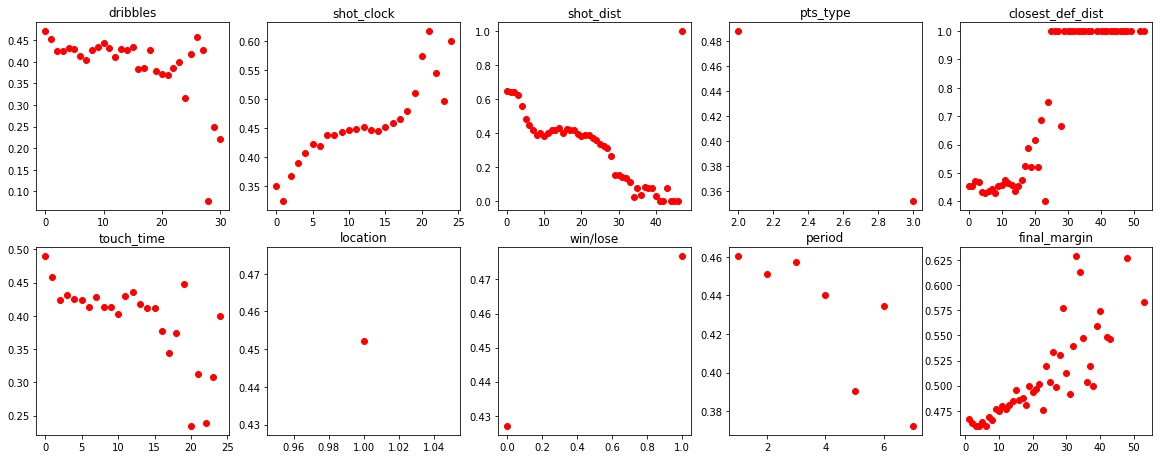

In [76]:
fig = plt.figure(figsize=(20,20))
for i in range(len(categories)):
    ratio, x_axis = createPlot(categories[i])
    ax1 = fig.add_subplot(len(categories)/2,len(categories)/2, i+1)
    plt.title(categories[i])
    plt.plot(x_axis, ratio, 'ro')